# Notebook 10.7

Julia Zeh, 4/6/18

reviewed by apf2139 (Alex Ferrena) instead of my assigned reviewee drs22col

In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import toyplot

C:\Users\Alexander\Miniconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### 1. Generate data

In [2]:
# fix a random seed
np.random.seed(12345)

# generate extinction data 1600 to 1840 with higher rates after 1760 (Industrial Revolution)
data = pd.DataFrame({
    "year": np.arange(1600, 1840),
    "extinctions": np.concatenate([
        np.random.poisson(5.0, 160), #5 extinctions on average (2 extinctions per year for the first 300 years) - based on the background extinction rate
        np.random.poisson(10.0, 80), #10 extinctions for the last 80 years
    ])
})

# introduce some random NaN values (pymc3 will handle these)
missing = np.random.randint(0, data.shape[0], 8) #sample 8 randomly
data.loc[missing, "extinctions"] = np.nan

In [3]:
data.head()

,extinctions,year
0,4.0,1600
1,7.0,1601
2,7.0,1602
3,8.0,1603
4,3.0,1604


In [4]:
# plot the generated data
toyplot.scatterplot(
    data.year,
    data.extinctions, 
    width=450, 
    height=300,
    size=8, 
    opacity=0.5,
    xlabel="year", 
    ylabel="N extinctions",
);

1600 1700 1800 year 0 5 10 15 20 N extinctions

### 2. Choose model

In [5]:
with pm.Model() as extinction_model:

    # sample switchpoint from within the bounds of our data timescale
    switchpoint = pm.DiscreteUniform( #sample points along this continuum of years - uniform distribution, discrete random variables
        'switchpoint',
        lower=data.year.min(), 
        upper=data.year.max(), 
        testval=1720)

    # Priors for pre- and post-switch rates for number of disasters
    early_rate = pm.Exponential('early_rate', 1.) #draw two exponential variables - wait time until disasters
    late_rate = pm.Exponential('late_rate', 1.)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= data.year, early_rate, late_rate) #rate is consequence of deterministic variables

    disasters = pm.Poisson('extinctions', rate, observed=data.extinctions)

### 3. Fit, plot, and summarize

In [6]:
with extinction_model:
    trace = pm.sample(10000)

Assigned Metropolis to switchpoint
Assigned NUTS to early_rate_log__
Assigned NUTS to late_rate_log__
Assigned Metropolis to extinctions_missing
C:\Users\Alexander\Miniconda3\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
100%|██████████| 10500/10500 [01:15<00:00, 139.18it/s]


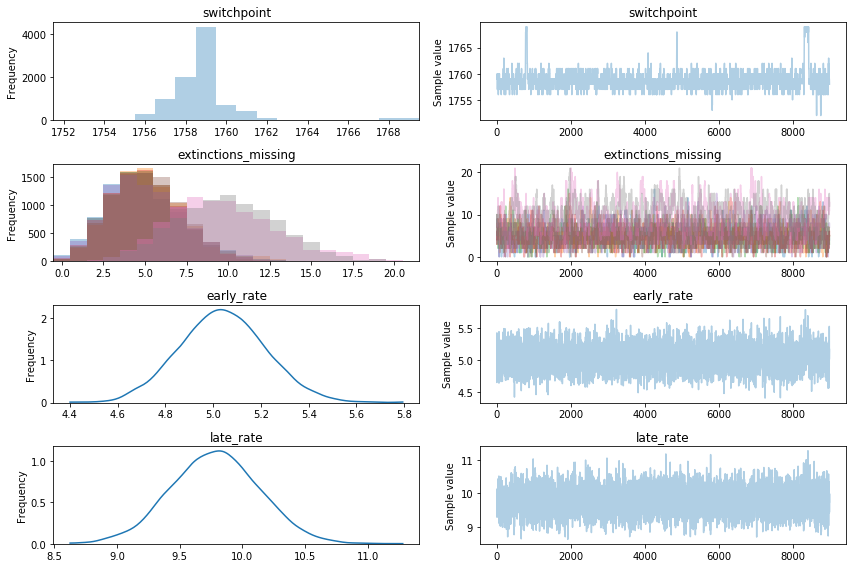

In [7]:
pm.traceplot(trace[1000:]); #slice to throw out the first 1000 variables

In [8]:
pm.summary(trace)


switchpoint:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  1758.827         1.701            0.100            [1756.000, 1761.000]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  1756.000       1758.000       1759.000       1759.000       1762.000


extinctions_missing:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  4.884            2.296            0.121            [1.000, 9.000]
  5.117            2.269            0.126            [1.000, 9.000]
  5.059            2.282            0.127            [1.000, 9.000]
  5.017            2.195            0.113            [1.000, 9.000]
  5.000            2.342            0.129            [1.000, 9.000]
  5.074            2.070        

### 4. Summary

My model very closely predicted my generative parameters. The posterior mean estimate is very close to 1760. The 95% HPD interval was 1757-1761, which includes my generative parameter of 1760. The early and rate lates were very close to 5 and 10, with a 95% HPD interval of 4.7-5.4 and 9.1-10.4.

I tried running the model for shorter and longer and the shorter MCMC sampler was less accurate. When I ran the MCMC sampler for longer,  the estimated switchpoints and the 95% HPD interval remained about the same, so I think I ran the sampler for long enough. I don't think anything went wrong, but I would have liked to try a more complex model which may have allowed for multiple switchpoints. I tried reading to find out if I could use the same model used here to predict multiple switchpoints, but had trouble finding something, so I kept my model simple. 

# code review - Alex Ferrena (apf2139)

#### What method did they use to generate data? What types of distributions did they sample data from? What type of data do these distributions generate?

The poisson method demonstrated in nb 10.6 was used to simulate extinction data over a range of years. Sampling was taken from a poisson distribution. THe informatin generated is discrete numerical values. The idea to analyze the rates of extinction before and after the industrial revoltuon was very cool.

#### What type of model did they try to fit with pymc3? Did they link to the tutorial that their analysis is based on. Which parameters of the model are they trying to fit.

The model utilized a discrete uniform distribution for the number of years and a poisson distribution for the number of extinctions. The model followed the example of nb 10.6.

#### Are they sampling data in their model from the same type of distribution that was used to generate the data?

Yes, the model uses the poisson distribtuion to extimate extinction

#### Do you agree or disagree with their assessment of the model fit? Did it work well? How might you suggest improving the model, or further testing this type of model?

I agree with the assesment that the model predicted the true parameters of switchpoint and early/late rates well (close to mean, within 95% HPD). It worked well. I am not sure why multiple switchpoints would be needed for this data, since the simulated data only really has one switchpoint. I suppose one could have included the concept of environmentalism and ecological protection as a later switchpoint after the industrial revolution, in which the extinction rate dropped (although probably not to pre-industrial levels). This would call for an additional switchpoint in the model. While this would be cool, this would certainly call for more complex code!

#### great work!